In [41]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [2]:
import os
import string
import glob  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow.keras.applications.resnet50


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_RESNET =  True

The following function is used to nicely format elapsed times.

In [0]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Google CoLab

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root_captioning = "/content/drive/My Drive/Datasets/Flickr8k"
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


### Running Locally

In [5]:
if not COLAB:
    root_captioning = "./data/captions"

### Clean/Build Dataset From Flickr8k

In [0]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text','Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


Stats on what was collected.

In [48]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


Load all images and display the amount found

In [6]:
img = glob.glob(os.path.join(root_captioning,'Flickr8k_Dataset', '*.jpg'))
len(img)

0

Read all image names and use the predefined train/test sets.

In [0]:
train_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

Display the size of the train and test sets.

In [52]:
print(len(train_images))
print(len(test_images))

6000
1000


Build the sequences bookended with start and stop tokens. The tokens do not affect training, but will be necessary during generation.

In [0]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'
len(train_descriptions)

### Pick an ImageNet model to Transfer

ResNet requires images to be 224x224
InceptionNet requires images to be 299x299

In [0]:
if USE_RESNET:
  encode_model = ResNet50(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  OUTPUT_DIM = 2048
  IMAGE_SIZE = 224
  preprocess_input = tensorflow.keras.applications.resnet50.preprocess_input
else:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  OUTPUT_DIM = 2048
  IMAGE_SIZE = 299
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

Chosen model architecture

In [56]:
encode_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Creating the Training Set

We we need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

In [0]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

We will spend a lot of time preprocessing each image, so rather than do it during train time or right before training, we'll do it once and then pickle the images.

In [58]:
train_path = os.path.join(root_captioning,"data",f'train{IMAGE_SIZE}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flickr8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 6000/6000 [47:55<00:00,  2.09it/s]



Generating training set took: 0:47:55.45


A similar process must also be performed for the test images.

In [59]:
test_path = os.path.join(root_captioning,"data",f'test{IMAGE_SIZE}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flickr8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s]


Generating testing set took: 0:07:36.11


Next we separate the captions that will be used for training.

In [60]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

To avoid needing to overcomplicate preprocessing, I've decided to remove words that appear less than 10 times. When training the model to use these words, having 10 or less instances will not be sufficient, so it's better to just remove it from the vocabulary entirely. This also managed to remove all the typos as well, which was an added benefit.

In [61]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next we build two lookup tables for this vocabulary. 

In [62]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

Previously we added a start and stop token to all sentences.  We need to account for these and use this max length for zero padding our sequences up ahead

In [22]:
max_length +=2
print(max_length)

34


### Using a Data Generator

Tensorflow supports in its fit function allowance for Data Generator functions to be passed instead of the data itself. This is useful because each image is being considered as a sample, but each image comes with five captions, and we want to have the model consider every sub sequence of the caption starting from the beginning.  Rather than dupicate the necessary parts for each of these cases to fill the dataset, the Data Generator can instead produce each case as needed without eating up nearly as much memory. The function uses a yield statement rather than a return, which returns a result while keeping the state saved, allowing subsequent results to be return on subsequent calls without as much time overhead. It functions similar to an iterator.

In [0]:
def data_generator(descriptions, photos, wordtoidx, max_length, batch_size):
    # x1 - Training data for photos
    # x2 - The caption that goes with each photo
    # y - The predicted rest of the caption
    x1, x2, y = [], [], []
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            # Each photo has 5 descriptions
            for desc in desc_list:
                # Convert each word into a list of sequences.
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
                # Generate a training case for every possible sequence and outcome
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
                if n==batch_size:
                    yield ([np.array(x1), np.array(x2)], np.array(y))
                    x1, x2, y = [], [], []
                    n=0

### Loading Glove Embeddings

In [64]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:19, 20359.68it/s]

Found 400000 word vectors.


### Building the Neural Network

An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

The matrix makes sense.  It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [66]:
embedding_matrix.shape

(1652, 200)

In [0]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, return_sequences=True)(se2)
se4 = LSTM(256)(se3)
decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [68]:
embedding_dim

200

In [79]:
caption_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 200)      330400      input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 32, 200)      0           embedding_3[0][0]                
____________________________________________________________________________________________

In [0]:
caption_model.layers[1].set_weights([embedding_matrix])
caption_model.layers[1].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train the Neural Network

In [0]:
batch_size = 3
steps = len(train_descriptions) // batch_size

In [83]:
start = time()
model_path = os.path.join(root_captioning,"data",f'caption-model_2.hdf5')
if not os.path.exists(model_path):
    for i in tqdm(range(EPOCHS*2)):
        generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, batch_size)
        caption_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    caption_model.optimizer.lr = 1e-4
    number_pics_per_bath = 6
    steps = len(train_descriptions) // batch_size

    for i in range(EPOCHS):
        generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, batch_size)
        caption_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
    caption_model.save_weights(model_path)
    print(f"\Training took: {hms_string(time()-start)}")
else:
    caption_model.load_weights(model_path)
    



  0%|          | 0/20 [00:00<?, ?it/s]

2000/2000 [==============================] - 349s 174ms/step - loss: 4.1662


  5%|▌         | 1/20 [05:54<1:52:22, 354.88s/it]

2000/2000 [==============================] - 348s 174ms/step - loss: 3.4276


 10%|█         | 2/20 [11:43<1:45:52, 352.90s/it]

2000/2000 [==============================] - 343s 171ms/step - loss: 3.1873


 15%|█▌        | 3/20 [17:25<1:39:07, 349.88s/it]

2000/2000 [==============================] - 340s 170ms/step - loss: 3.0434


 20%|██        | 4/20 [23:06<1:32:32, 347.01s/it]

2000/2000 [==============================] - 336s 168ms/step - loss: 2.9356


 25%|██▌       | 5/20 [28:42<1:25:56, 343.77s/it]

2000/2000 [==============================] - 337s 168ms/step - loss: 2.8534


 30%|███       | 6/20 [34:19<1:19:44, 341.73s/it]

2000/2000 [==============================] - 344s 172ms/step - loss: 2.7830


 35%|███▌      | 7/20 [40:03<1:14:11, 342.44s/it]

2000/2000 [==============================] - 336s 168ms/step - loss: 2.7236


 40%|████      | 8/20 [45:39<1:08:06, 340.54s/it]

2000/2000 [==============================] - 333s 167ms/step - loss: 2.6718


 45%|████▌     | 9/20 [51:13<1:02:02, 338.43s/it]

2000/2000 [==============================] - 333s 166ms/step - loss: 2.6288


 50%|█████     | 10/20 [56:46<56:07, 336.78s/it] 

2000/2000 [==============================] - 332s 166ms/step - loss: 2.5878


 55%|█████▌    | 11/20 [1:02:18<50:20, 335.56s/it]

2000/2000 [==============================] - 335s 167ms/step - loss: 2.5497


 60%|██████    | 12/20 [1:07:53<44:43, 335.38s/it]

2000/2000 [==============================] - 334s 167ms/step - loss: 2.5179


 65%|██████▌   | 13/20 [1:13:28<39:05, 335.12s/it]

2000/2000 [==============================] - 335s 168ms/step - loss: 2.4835


 70%|███████   | 14/20 [1:19:03<33:31, 335.17s/it]

2000/2000 [==============================] - 334s 167ms/step - loss: 2.4548


 75%|███████▌  | 15/20 [1:24:37<27:53, 334.76s/it]

2000/2000 [==============================] - 335s 167ms/step - loss: 2.4302


 80%|████████  | 16/20 [1:30:12<22:19, 334.89s/it]

2000/2000 [==============================] - 337s 169ms/step - loss: 2.4038


 85%|████████▌ | 17/20 [1:35:50<16:47, 335.72s/it]

2000/2000 [==============================] - 335s 167ms/step - loss: 2.3803


 90%|█████████ | 18/20 [1:41:25<11:10, 335.43s/it]

2000/2000 [==============================] - 335s 168ms/step - loss: 2.3592


 95%|█████████▌| 19/20 [1:47:00<05:35, 335.44s/it]

2000/2000 [==============================] - 332s 166ms/step - loss: 2.3400


100%|██████████| 20/20 [1:52:32<00:00, 337.64s/it]


1000/1000 [==============================] - 175s 175ms/step - loss: 2.1453
\Training took: 3:58:16.96


### Generating Captions

It is important to understand that a caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which are mapped to the input neurons).  The first is the photo.  The second is an ever growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  This continues until an end token is predicted or we reach the maximum length of a caption.  Each time predict a new word is predicted for the caption.  The word that has the highest probability (from the neural network) is chosen. 

In [0]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data from Flicker8k

The caption model performs relativly well on images that are similar to what it trained on.

/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/384577800_fc325af410.jpg


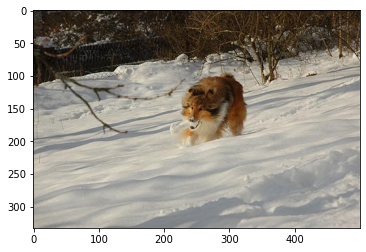

Caption: two dogs are running through snow covered ground
_____________________________________
/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/387830531_e89c192b92.jpg


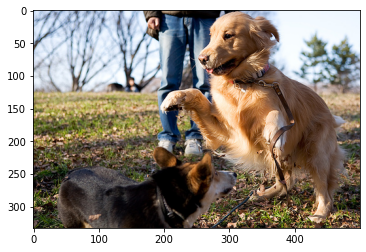

Caption: two dogs are playing with red ball in the yard
_____________________________________
/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/391579205_c8373b5411.jpg


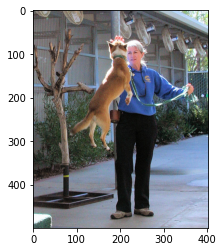

Caption: dog jumps to catch tennis ball
_____________________________________
/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/396360611_941e5849a3.jpg


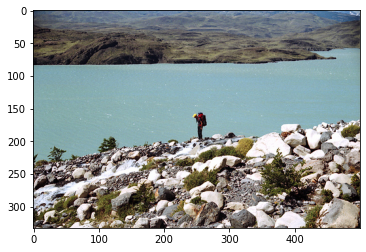

Caption: man is fishing on the edge of cliff overlooking the ocean
_____________________________________
/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/398662202_97e5819b79.jpg


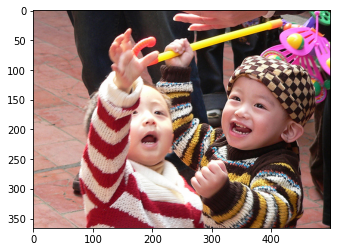

Caption: two little boys are sitting on the grass
_____________________________________
/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/400851260_5911898657.jpg


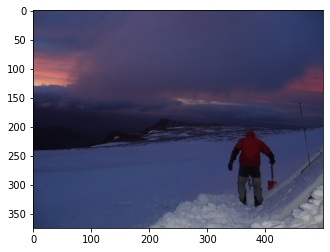

Caption: man in red jacket is skiing down snowy hill
_____________________________________
/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/401079494_562454c4d6.jpg


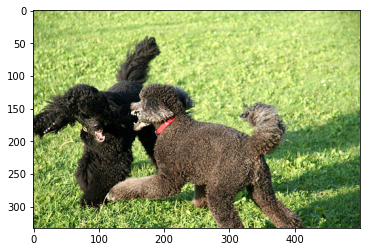

Caption: black dog is running along the grass carrying pink toy in its mouth
_____________________________________
/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/405615014_03be7ef618.jpg


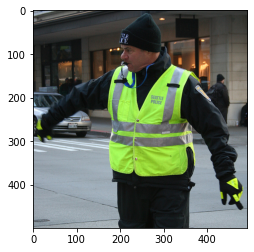

Caption: woman in black and white crossing street
_____________________________________
/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/410453140_5401bf659a.jpg


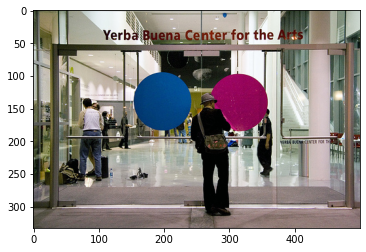

Caption: man in red shirt is standing next to two men in front of store
_____________________________________
/content/drive/My Drive/Datasets/Flickr8k/Flickr8k_Dataset/415793623_6c1225ae27.jpg


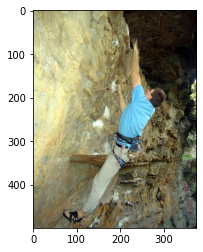

Caption: man climbing steep rock wall
_____________________________________


In [85]:
for z in range(10):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,OUTPUT_DIM))
    print(os.path.join(root_captioning,'Flickr8k_Dataset', pic))
    x=plt.imread(os.path.join(root_captioning,'Flickr8k_Dataset', pic))
    plt.imshow(x)
    plt.show()
    print("Caption:",generateCaption(image))
    print("_____________________________________\n")